# ORIGEN — Lorenz-63: Observation-based Reconstruction + Learned Dynamics

This notebook is a compact end-to-end demo of **ORIGEN** on the Lorenz-63 system:

1. **Generate truth**: simulate a Lorenz-63 trajectory (*x(t), y(t), z(t)*).
2. **Create observations**: observe only a subset of variables (e.g. **x,z** or **x,y**) and add Gaussian noise.
3. **Reconstruct the full state (3D-Var)**:
   - Use a linear observation operator **H**
   - Use a Gaussian background covariance **B**
   - Compute the analysis **xᵃ(t)** from background **xᵇ(t)** and observations **y(t)**
4. **Iterative reconstruction with covariance updates**:
   - Perform repeated analysis cycles
   - Update the covariance **B → Pᵃ** (Kalman-style), improving the reconstruction
   - Store **all reconstructed trajectories** across iterations
5. **Learn dynamics from reconstructions**:
   - Train a small neural network to learn the one-step map  
     **xᵃ(k) → xᵃ(k+1)**
   - Evaluate by rollout forecasts (long rollout + short forecasts from many start times)
   - Optionally stabilize via rollout-aware fine-tuning

All plots and generated figures are stored in the folder:

`origen_l63/`


In [1]:
import random
import numpy as np
import torch

SEED = 42

# --- seeds ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# --- deterministic (esp. CNN on GPU) ---
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# reusable NumPy RNG for all new random draws
rng = np.random.default_rng(SEED)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [2]:
# =========================================================
# Cell 1: Lorenz-63 truth trajectory + noisy observations
# Output folder: origen_l63/
# =========================================================
import os
import numpy as np
from scipy.integrate import solve_ivp

# ---------------------------------------------------------
# Output directory (use this everywhere in the notebook)
# ---------------------------------------------------------
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# ---------------------------------------------------------
# Lorenz-63 dynamics
# ---------------------------------------------------------
def lorenz63(t, state, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """Lorenz-63 ODE: d/dt [x,y,z] = f(x,y,z)."""
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# ---------------------------------------------------------
# Simulate truth + create partial observations (with noise)
# ---------------------------------------------------------
def generate_l63_observations(
    t_max=10.0,
    dt=0.01,
    x0=(0.0, 1.0, 20.0),
    measured="xyz",               # 'x','y','z','xy','xz','yz','xyz'
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0,
    noise_std=0.0,
):
    """
    Integrate Lorenz-63 and return:
      t      : (nt,) time grid
      truth  : (nt,3) true trajectory [x,y,z]
      obs    : (nt,m) observed components (with Gaussian noise)
    """
    t_eval = np.linspace(0.0, t_max, int(round(t_max / dt)) + 1)

    sol = solve_ivp(
        fun=lorenz63,
        t_span=(0.0, t_max),
        y0=x0,
        args=(sigma, rho, beta),
        t_eval=t_eval,
        rtol=1e-9,
        atol=1e-9,
    )

    truth = sol.y.T  # (nt, 3)
    x, y, z = truth[:, 0], truth[:, 1], truth[:, 2]

    obs_map = {
        "x":   np.column_stack([x]),
        "y":   np.column_stack([y]),
        "z":   np.column_stack([z]),
        "xy":  np.column_stack([x, y]),
        "xz":  np.column_stack([x, z]),
        "yz":  np.column_stack([y, z]),
        "xyz": np.column_stack([x, y, z]),
    }
    if measured not in obs_map:
        raise ValueError(f"measured must be one of {list(obs_map.keys())}, got {measured!r}")

    obs = obs_map[measured].copy()

    if noise_std > 0.0:
        obs += np.random.normal(loc=0.0, scale=noise_std, size=obs.shape)

    return t_eval, truth, obs

# ---------------------------------------------------------
# Parameters + run
# ---------------------------------------------------------
measured = "xz"   # choose: 'x','y','z','xy','xz','yz','xyz'

t, truth, obs = generate_l63_observations(
    t_max=20.0,
    dt=0.1,
    measured=measured,
    noise_std=0.1,
)

print(f"Generated observations: measured={measured.upper()}  truth={truth.shape}  obs={obs.shape}")


Generated observations: measured=XZ  truth=(201, 3)  obs=(201, 2)


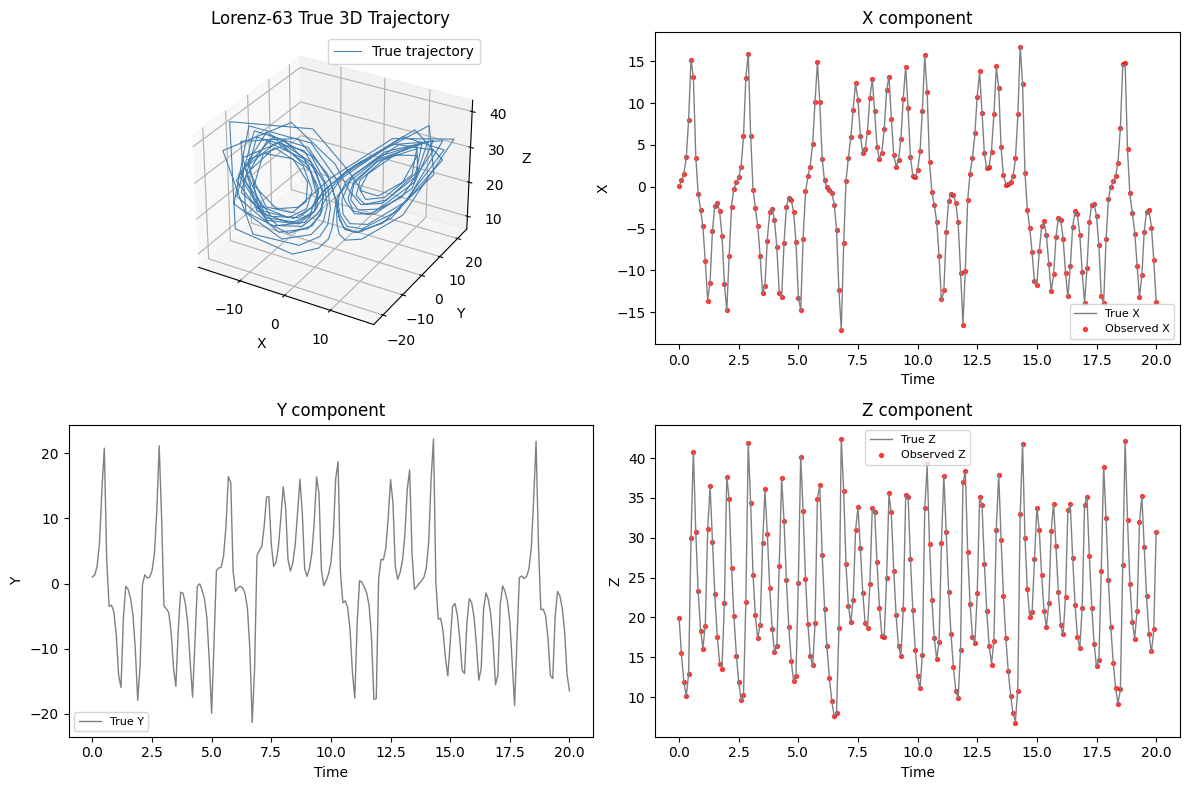

Saved plot to: origen_l63/L63_1_truth_and_obs_example.png


In [3]:
# =========================================================
# Cell 2: Plot Lorenz-63 truth and observations
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# make sure output folder exists (same convention as Cell 1)
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

fig = plt.figure(figsize=(12, 8))

# --- 3D trajectory ---
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot(truth[:, 0], truth[:, 1], truth[:, 2],
         color='steelblue', lw=0.8, label='True trajectory')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Lorenz-63 True 3D Trajectory')
ax1.legend()

# --- component-wise time series ---
components = ['X', 'Y', 'Z']
obs_map = {
    'xyz': [0, 1, 2],
    'xy': [0, 1],
    'xz': [0, 2],
    'yz': [1, 2],
    'x': [0],
}
obs_indices = obs_map[measured]

for i in range(3):
    ax = fig.add_subplot(2, 2, i + 2)
    ax.plot(t, truth[:, i], color='gray', lw=1.0, label=f'True {components[i]}')

    if i in obs_indices:
        obs_col = obs_indices.index(i)
        ax.scatter(t, obs[:, obs_col], color='red', s=8,
                   label=f'Observed {components[i]}', alpha=0.7)
    ax.set_xlabel('Time')
    ax.set_ylabel(components[i])
    ax.legend(fontsize=8)
    ax.set_title(f'{components[i]} component')

plt.tight_layout()
plt.savefig("L63_1_truth_and_obs_example.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_1_truth_and_obs_example.png", os.path.join(OUTDIR, "L63_1_truth_and_obs_example.png"))
print(f"Saved plot to: {OUTDIR}/L63_1_truth_and_obs_example.png")


In [4]:
# =========================================================
# Cell 3: 3D-Var solver (linear) with Gaussian background B
# =========================================================
import numpy as np

def build_H_matrix(measured: str):
    """Return H matrix mapping full state (x,y,z) -> observed subset."""
    mapping = {
        'x':  [0],
        'y':  [1],
        'z':  [2],
        'xy': [0, 1],
        'xz': [0, 2],
        'yz': [1, 2],
        'xyz':[0, 1, 2]
    }
    cols = mapping[measured]
    H = np.zeros((len(cols), 3))
    for i, c in enumerate(cols):
        H[i, c] = 1.0
    return H

def gaussian_B_matrix(length_scale=1.0, variance=1.0):
    """Construct symmetric Gaussian 3x3 background covariance matrix B."""
    n = 3
    B = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            B[i, j] = variance * np.exp(-((i-j)**2) / (2 * length_scale**2))
    return B

def var3d_analysis(xb_v, y_v, H, B, R):
    """Compute 3D-Var analysis for xb_v given observations y_v (linear H)."""
    HBHT = H @ B @ H.T
    K = B @ H.T @ np.linalg.inv(HBHT + R)  # Kalman gain (3D-Var form)
    xa_v = xb_v + K @ (y_v - H @ xb_v)     # analysis update
    return xa_v, K


In [5]:
# =========================================================
# Cell 4: Run a single 3D-Var analysis test (xb = 0)
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# pick an observation time (e.g. midpoint)
idx = len(t)//2
y_v = obs[idx]  # observation vector at this time
truth_v = truth[idx]  # true state at this time
xb_v = np.zeros(3)  # background = 0

# matrices
H = build_H_matrix(measured)
B = gaussian_B_matrix(length_scale=0.7, variance=4.0)
R = np.eye(len(y_v)) * 0.2**2

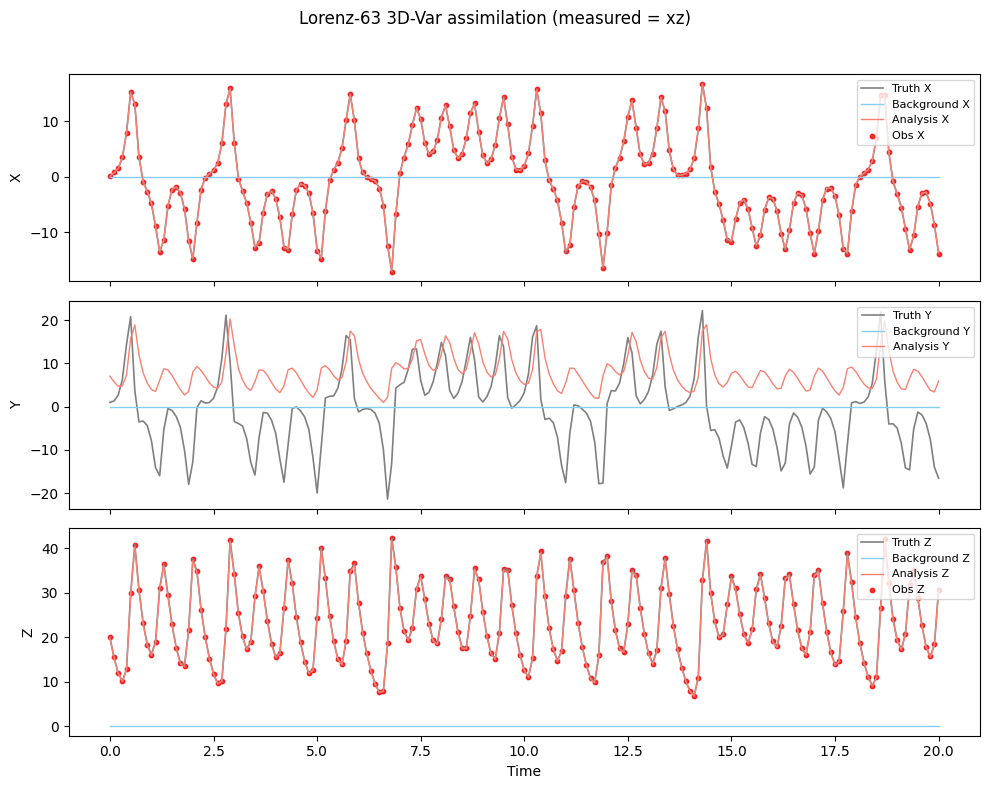

Saved plot to: origen_l63/L63_2_a_rec_01.png


In [6]:
# =========================================================
# Cell 5: Sequential 3D-Var analysis for all time steps
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# --- setup matrices ---
H = build_H_matrix(measured)
B = gaussian_B_matrix(length_scale=0.7, variance=4.0)
R = np.eye(H.shape[0]) * 0.2**2

# --- background: xb = 0 for all time steps ---
xb = np.zeros((len(t), 3))
xa = np.zeros_like(xb)

# --- perform 3D-Var for each time step ---
for k in range(len(t)):
    y_v = obs[k]
    xb_v = xb[k]
    xa[k], _ = var3d_analysis(xb_v, y_v, H, B, R)

# --- plot all components ---
components = ['X', 'Y', 'Z']
obs_map = {'x':[0],'xy':[0,1],'xz':[0,2],'yz':[1,2],'xyz':[0,1,2]}
obs_indices = obs_map[measured]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i, comp in enumerate(components):
    ax = axs[i]
    ax.plot(t, truth[:, i], color='gray', lw=1.2, label=f'Truth {comp}')
    ax.plot(t, xb[:, i], color='skyblue', lw=1.0, label=f'Background {comp}')
    ax.plot(t, xa[:, i], color='salmon', lw=1.0, label=f'Analysis {comp}')
    
    # add observations if available
    if i in obs_indices:
        obs_col = obs_indices.index(i)
        ax.scatter(t, obs[:, obs_col],
                   color='red', s=10, label=f'Obs {comp}', alpha=0.8)
    
    ax.set_ylabel(comp)
    ax.legend(fontsize=8, loc='upper right')

axs[-1].set_xlabel("Time")
fig.suptitle(f"Lorenz-63 3D-Var assimilation (measured = {measured})", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("L63_2_a_rec_01.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_2_a_rec_01.png", os.path.join(OUTDIR, "L63_2_a_rec_01.png"))
print(f"Saved plot to: {OUTDIR}/L63_2_a_rec_01.png")

Stage A (measured = xz) with Kalman Pa computed.
Stage B (measured = xy) using B_k = Pa_A[k] done.


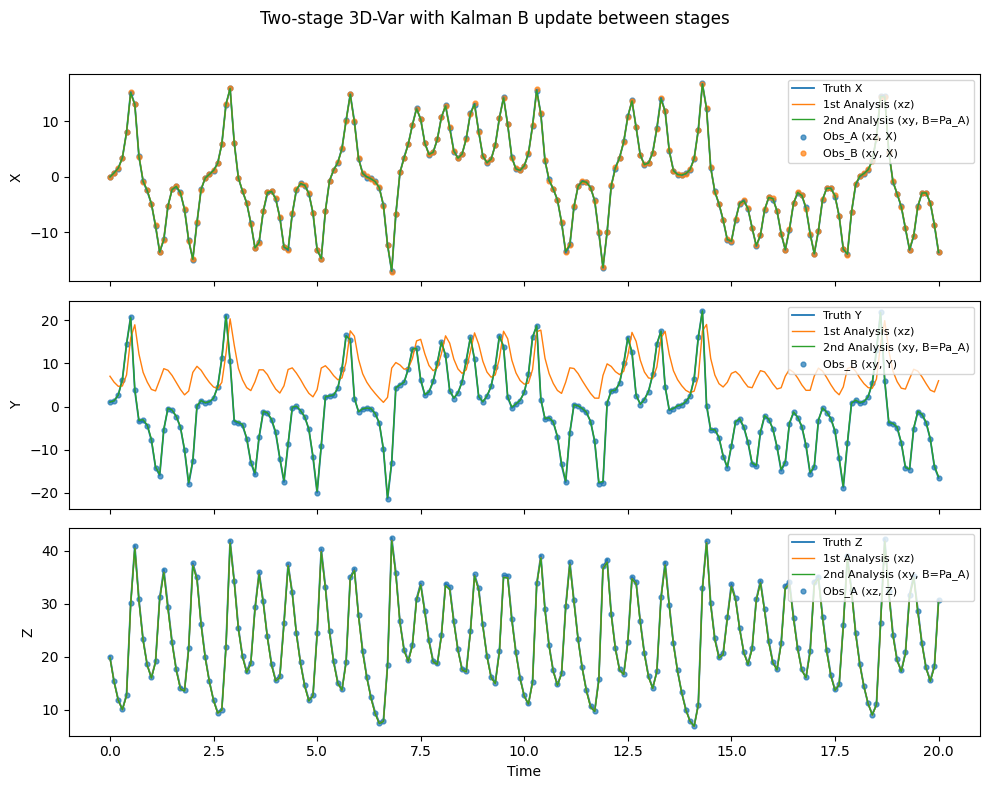

Saved plot to: origen_l63/L63_2_b_rec_2_steps.png


In [7]:
# =========================================================
# Cell 6: Two-stage 3D-Var with Kalman B updates
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

def var3d_kalman_step(xb_v, y_v, H, B, R):
    """Single 3D-Var / Kalman-style analysis step returning xa, K, and Pa."""
    # Innovation covariance
    S = H @ B @ H.T + R
    # Gain
    K = B @ H.T @ np.linalg.inv(S)
    # Analysis state
    xa_v = xb_v + K @ (y_v - H @ xb_v)
    # Analysis covariance (Joseph form: symmetric + PSD)
    I = np.eye(B.shape[0])
    Pa = (I - K @ H) @ B @ (I - K @ H).T + K @ R @ K.T
    return xa_v, K, Pa

# --- Stage A: generate x,z observations and assimilate (B constant initially) ---
measured_A = "xz"
t, truth, obs_A = generate_l63_observations(
    t_max=20.0, dt=0.1, measured=measured_A, noise_std=0.1
)

H_A = build_H_matrix(measured_A)
# Initial background covariance
B0 = gaussian_B_matrix(length_scale=0.7, variance=4.0)
R_A = np.eye(H_A.shape[0]) * 0.2**2

xb_A = np.zeros((len(t), 3))
xa_A = np.zeros_like(xb_A)
Pa_A = np.zeros((len(t), 3, 3))  # per-time analysis covariance

for k in range(len(t)):
    y_v = obs_A[k]
    xb_v = xb_A[k]
    xa_k, K_k, Pa_k = var3d_kalman_step(xb_v, y_v, H_A, B0, R_A)
    xa_A[k] = xa_k
    Pa_A[k] = Pa_k

print("Stage A (measured = xz) with Kalman Pa computed.")

# --- Stage B: generate x,y observations and assimilate using Pa_A[k] as B_k ---
measured_B = "xy"
_, _, obs_B = generate_l63_observations(
    t_max=20.0, dt=0.1, measured=measured_B, noise_std=0.1
)
H_B = build_H_matrix(measured_B)
R_B = np.eye(H_B.shape[0]) * 0.2**2

# Background for Stage B is the Stage A analysis (state), and B_k = Pa_A[k]
xb_B = xa_A.copy()
xa_B = np.zeros_like(xb_B)

for k in range(len(t)):
    y_v = obs_B[k]
    xb_v = xb_B[k]
    Bk = Pa_A[k]  # adapt B between stages following Kalman update
    xa_k, K_k, Pa_k = var3d_kalman_step(xb_v, y_v, H_B, Bk, R_B)
    xa_B[k] = xa_k
    # (Optional) store Pa_k if you plan further stages

print("Stage B (measured = xy) using B_k = Pa_A[k] done.")

# =========================================================
# Visualization: truth, first analysis, second analysis, observations
# =========================================================
components = ['X', 'Y', 'Z']
obs_map = {'x':[0],'xy':[0,1],'xz':[0,2],'yz':[1,2],'xyz':[0,1,2]}
obs_idx_A = obs_map[measured_A]
obs_idx_B = obs_map[measured_B]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i, comp in enumerate(components):
    ax = axs[i]
    ax.plot(t, truth[:, i], lw=1.3, label=f'Truth {comp}')
    ax.plot(t, xa_A[:, i], lw=1.0, label='1st Analysis (xz)')
    ax.plot(t, xa_B[:, i], lw=1.0, label='2nd Analysis (xy, B=Pa_A)')

    # Stage A observations
    if i in obs_idx_A:
        colA = obs_idx_A.index(i)
        ax.scatter(t, obs_A[:, colA], s=12, alpha=0.7, label=f'Obs_A ({measured_A}, {comp})')
    # Stage B observations
    if i in obs_idx_B:
        colB = obs_idx_B.index(i)
        ax.scatter(t, obs_B[:, colB], s=12, alpha=0.7, label=f'Obs_B ({measured_B}, {comp})')

    ax.set_ylabel(comp)
    ax.legend(fontsize=8, loc='upper right')

axs[-1].set_xlabel("Time")
fig.suptitle("Two-stage 3D-Var with Kalman B update between stages", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("L63_2_b_rec_2_steps.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_2_b_rec_2_steps.png", os.path.join(OUTDIR, "L63_2_b_rec_2_steps.png"))
print(f"Saved plot to: {OUTDIR}/L63_2_b_rec_2_steps.png")

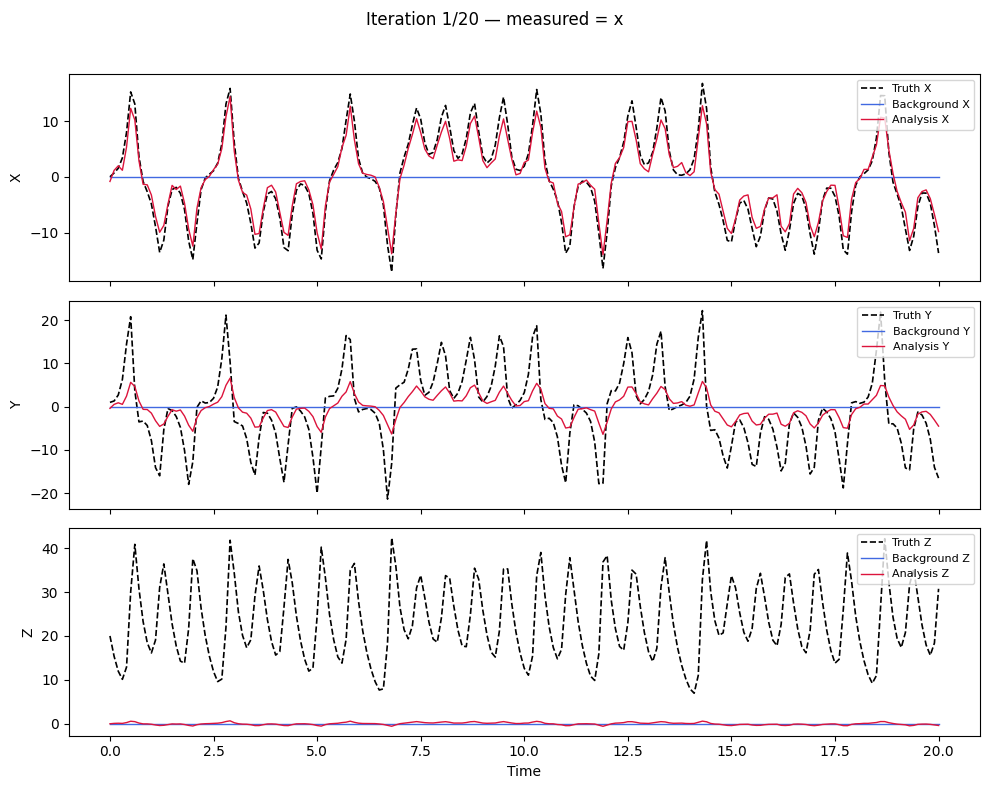

Saved plot to: origen_l63/L63_3_1_origen.png


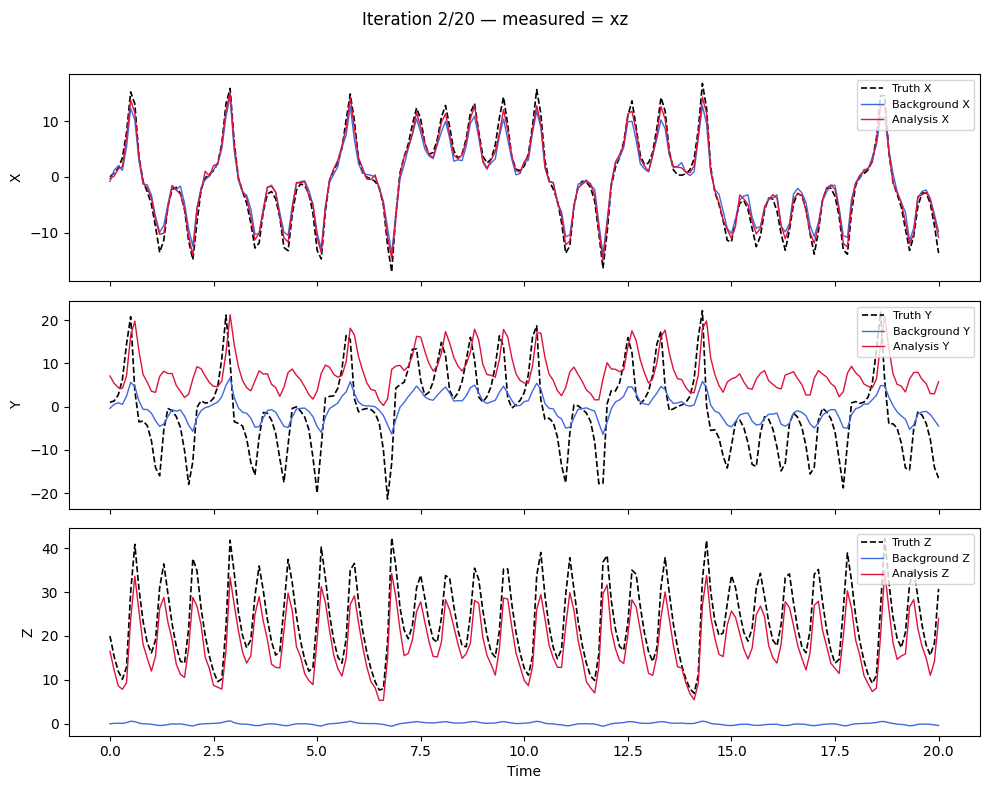

Saved plot to: origen_l63/L63_3_2_origen.png


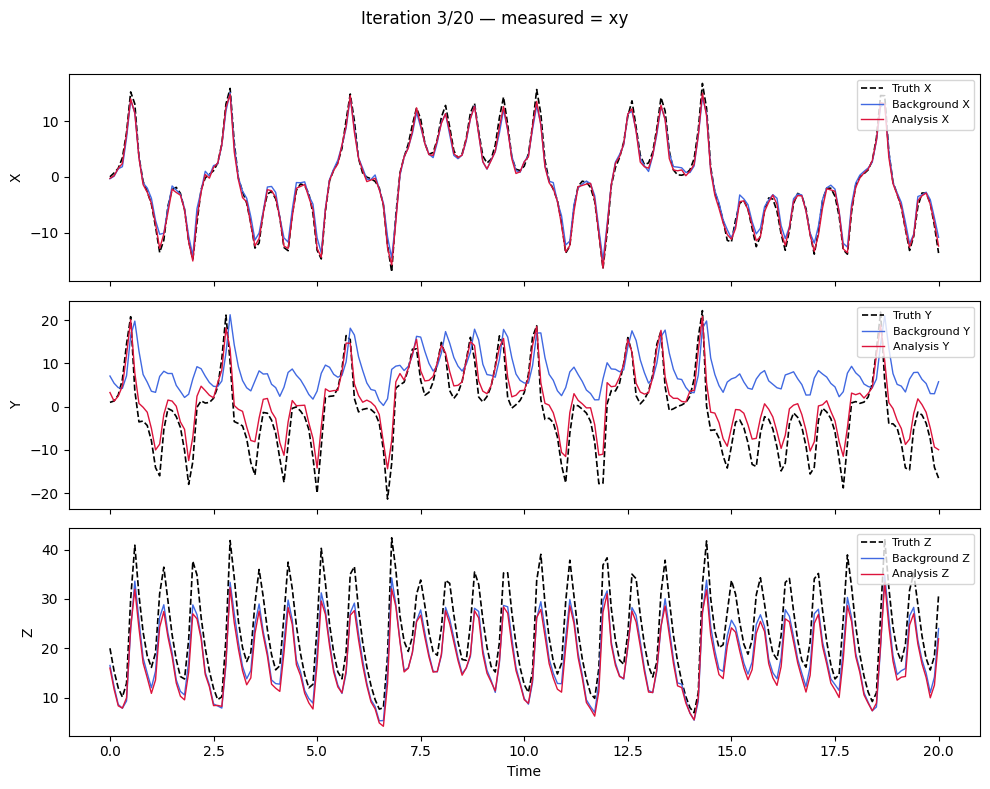

Saved plot to: origen_l63/L63_3_3_origen.png


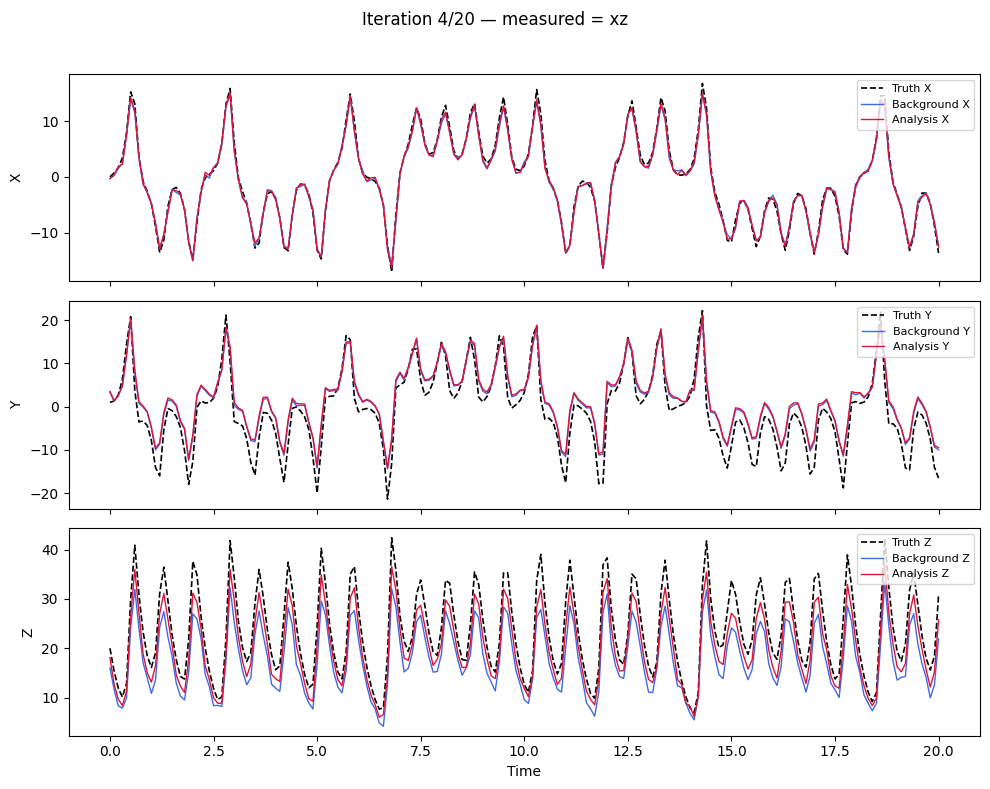

Saved plot to: origen_l63/L63_3_4_origen.png


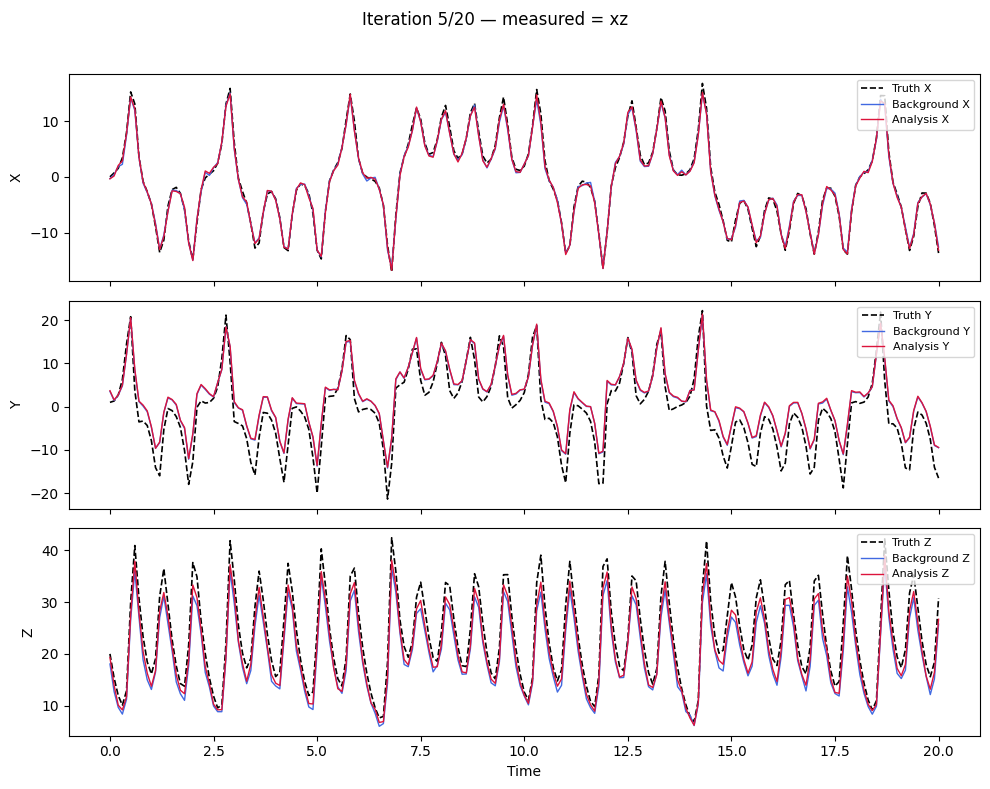

Saved plot to: origen_l63/L63_3_5_origen.png


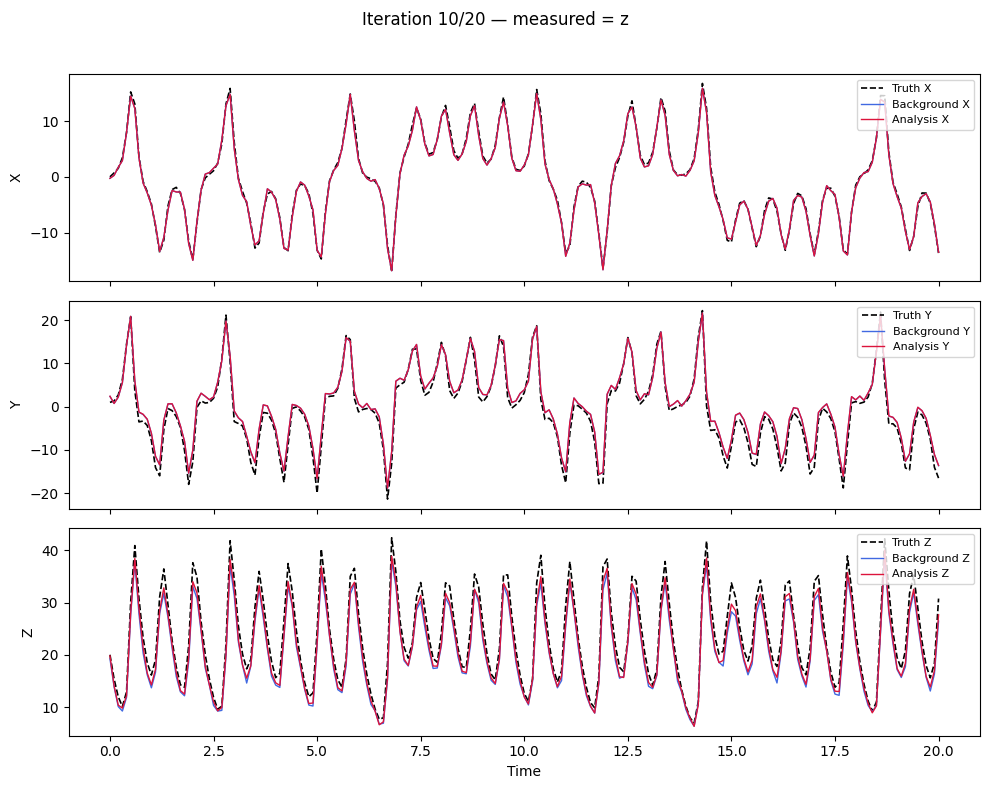

Saved plot to: origen_l63/L63_3_10_origen.png


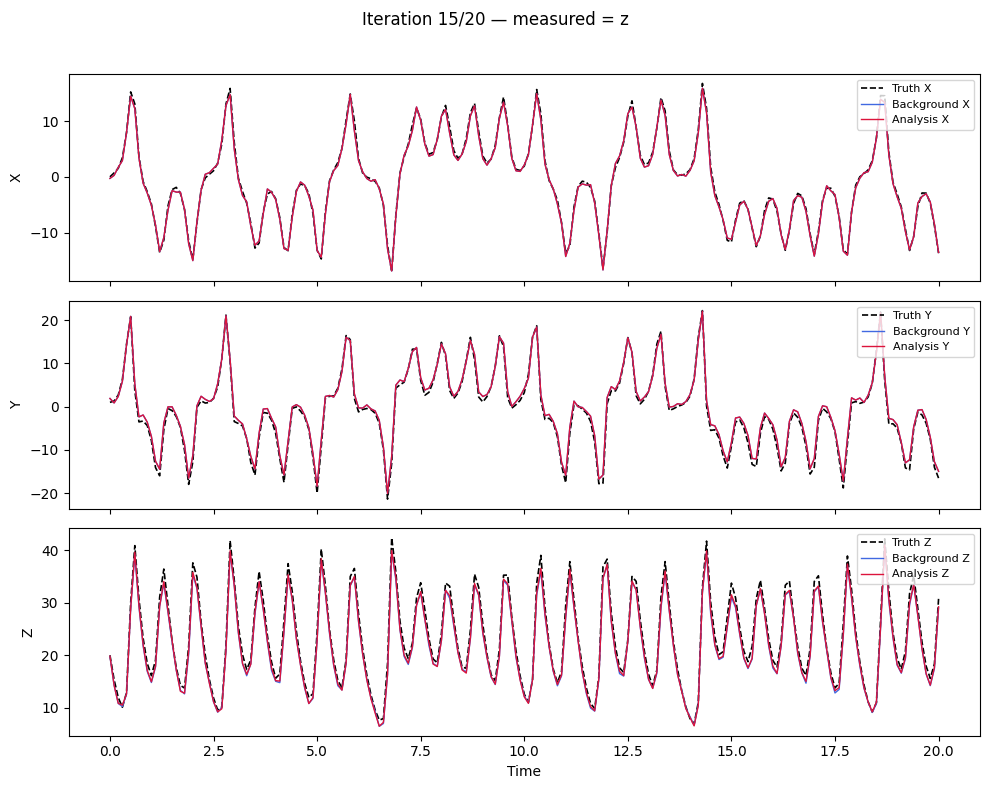

Saved plot to: origen_l63/L63_3_15_origen.png


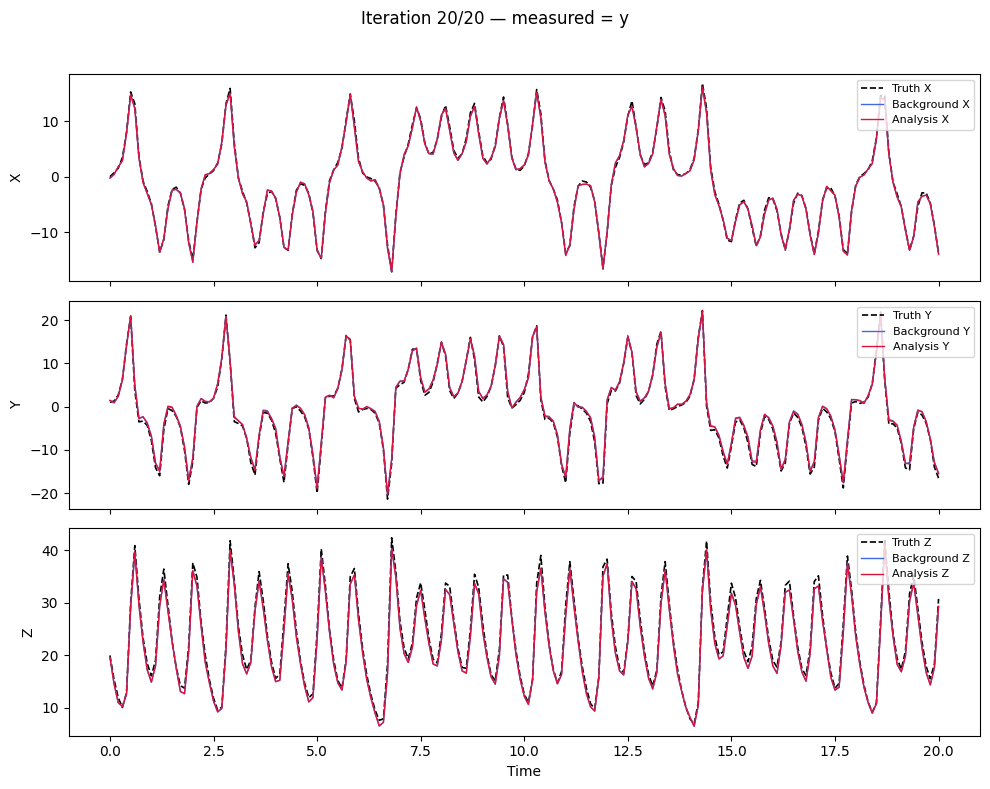

Saved plot to: origen_l63/L63_3_20_origen.png
All iterations stored: xa_all.shape = (20, 201, 3)


In [8]:
# =========================================================
# Cell 7: Enhanced iterative 3D-Var storing all xa over time
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

N_iter = 20
obs_noise_std = 1.0
rng = np.random.default_rng(42)
measured_options = ["x", "y", "z", "xy", "xz", "yz"]

B0 = gaussian_B_matrix(length_scale=0.8, variance=4.0)
xb = np.zeros_like(truth)
B_arr = np.repeat(B0[None, :, :], len(t), axis=0)
components = ["X", "Y", "Z"]

# --- helper: make noisy observations from truth ---
def obs_from_truth(truth_arr, measured: str, noise_std: float, rng=None):
    """Construct observation vectors from the given truth trajectory."""
    import numpy as np
    if rng is None:
        rng = np.random.default_rng()
    x, y, z = truth_arr[:, 0], truth_arr[:, 1], truth_arr[:, 2]
    obs_dict = {
        "x":  np.column_stack([x]),
        "y":  np.column_stack([y]),
        "z":  np.column_stack([z]),
        "xy": np.column_stack([x, y]),
        "xz": np.column_stack([x, z]),
        "yz": np.column_stack([y, z]),
    }
    obs = obs_dict[measured].copy()
    obs += rng.normal(scale=noise_std, size=obs.shape)
    return obs

# --- storage array: (iterations, time, 3 variables) ---
xa_all = np.zeros((N_iter, len(t), 3))

for it in range(N_iter):
    measured_it = str(rng.choice(measured_options))
    H = build_H_matrix(measured_it)
    R = np.eye(H.shape[0]) * (obs_noise_std ** 2)
    obs_it = obs_from_truth(truth, measured_it, noise_std=obs_noise_std, rng=rng)

    xa_it = np.zeros_like(truth)
    Pa_it = np.zeros((len(t), 3, 3))
    for k in range(len(t)):
        xa_k, K_k, Pa_k = var3d_kalman_step(xb[k], obs_it[k], H, B_arr[k], R)
        xa_it[k] = xa_k
        Pa_it[k] = Pa_k

    # store full iteration analysis
    xa_all[it] = xa_it

    # diagnostic plot every 5th iteration
    if (it+1) < 5 or (it + 1) % 5 == 0:
        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
        for i, comp in enumerate(components):
            ax = axs[i]
            ax.plot(t, truth[:, i], linestyle='--', lw=1.2, color='black', label=f"Truth {comp}")
            ax.plot(t, xb[:, i], color='royalblue', lw=1.0, label=f"Background {comp}")
            ax.plot(t, xa_it[:, i], color='crimson', lw=1.0, label=f"Analysis {comp}")
            ax.set_ylabel(comp)
            ax.legend(fontsize=8, loc='upper right')
        axs[-1].set_xlabel("Time")
        fig.suptitle(f"Iteration {it+1}/{N_iter} — measured = {measured_it}", fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"L63_3_{it+1}_origen.png")
        plt.show()

        # copy plot into origen_l63/ without touching your save line above
        fn = f"L63_3_{it+1}_origen.png"
        shutil.copy(fn, os.path.join(OUTDIR, fn))
        print(f"Saved plot to: {OUTDIR}/{fn}")

    # update background and covariance
    xb = xa_it.copy()
    B_arr = Pa_it.copy()

print("All iterations stored: xa_all.shape =", xa_all.shape)

Using device: mps


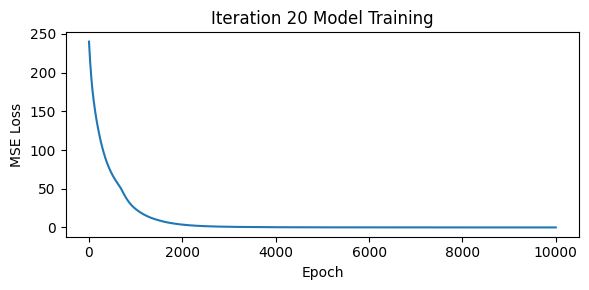

Saved plot to: origen_l63/L63_4_train_1.png


In [9]:
# =========================================================
# Cell 8: Train PyTorch model to learn xa(k) -> xa(k+1)
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# --- choose device (Mac: use MPS if available) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# --- configuration ---
iter_to_train = 19      # choose iteration (0-indexed)
n_epochs = 10000
lr = 1e-3
hidden = 32

# --- prepare training data ---
xa = xa_all[iter_to_train]                 # (T,3)
X = xa[:-1]                                # inputs xa(k)
Y = xa[1:]                                 # targets xa(k+1)
X_t = torch.tensor(X, dtype=torch.float32, device=device)
Y_t = torch.tensor(Y, dtype=torch.float32, device=device)

# --- simple feedforward model ---
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 3)
        )
    def forward(self, x):
        return self.net(x)

model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# --- training loop ---
losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = model(X_t)
    loss = loss_fn(y_pred, Y_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# --- training diagnostics ---
plt.figure(figsize=(6,3))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Iteration {iter_to_train+1} Model Training")
plt.tight_layout()
plt.savefig("L63_4_train_1.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_4_train_1.png", os.path.join(OUTDIR, "L63_4_train_1.png"))
print(f"Saved plot to: {OUTDIR}/L63_4_train_1.png")


Using device: mps:0


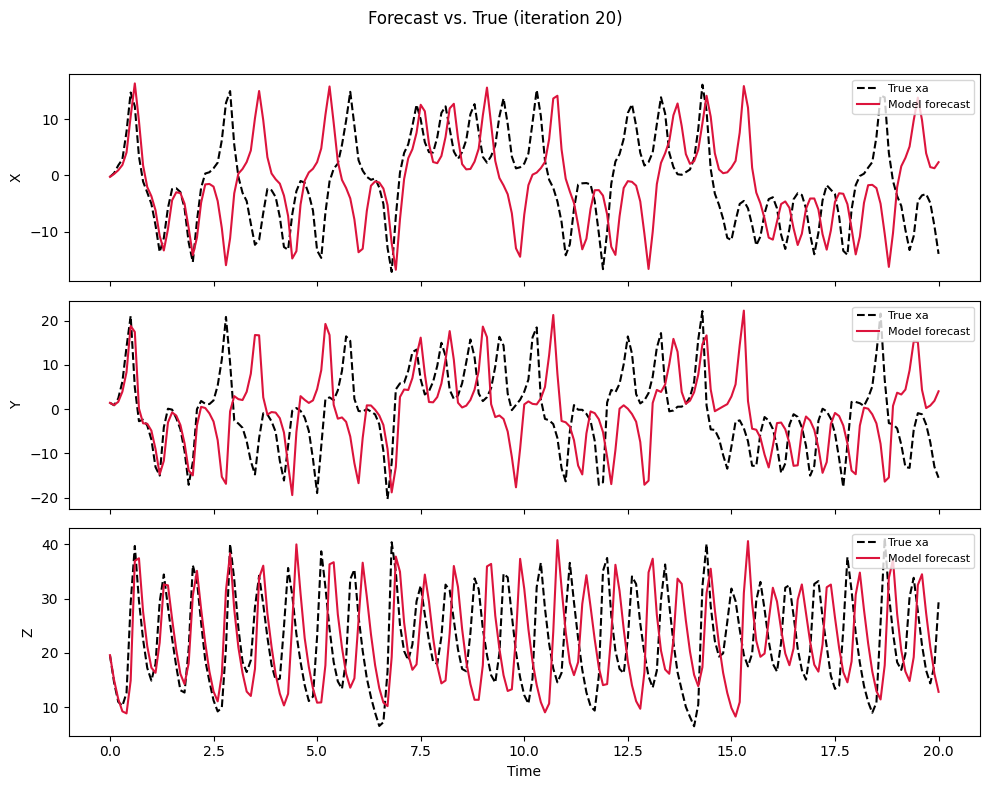

Saved plot to: origen_l63/L63_5_trajectory_test_1.png


In [10]:
# =========================================================
# Cell 9: Evaluate learned model by rollout forecast
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# --- determine device from model (important!) ---
device = next(model.parameters()).device
print("Using device:", device)

# --- evaluation: roll out forecasts from xa(k) initial ---
xa_true = xa_all[iter_to_train]
xa_pred = np.zeros_like(xa_true)
xa_pred[0] = xa_true[0]
model.eval()
with torch.no_grad():
    for k in range(len(t)-1):
        x_in = torch.tensor(xa_pred[k], dtype=torch.float32, device=device)
        xa_pred[k+1] = model(x_in).detach().cpu().numpy()

# --- plot comparison (forecast vs true xa) ---
fig, axs = plt.subplots(3,1, figsize=(10,8), sharex=True)
comps = ["X", "Y", "Z"]
for i, comp in enumerate(comps):
    axs[i].plot(t, xa_true[:, i], '--', label="True xa", color='black')
    axs[i].plot(t, xa_pred[:, i], label="Model forecast", color='crimson')
    axs[i].set_ylabel(comp)
    axs[i].legend(loc='upper right', fontsize=8)
axs[-1].set_xlabel("Time")
fig.suptitle(f"Forecast vs. True (iteration {iter_to_train+1})", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig("L63_5_trajectory_test_1.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_5_trajectory_test_1.png", os.path.join(OUTDIR, "L63_5_trajectory_test_1.png"))
print(f"Saved plot to: {OUTDIR}/L63_5_trajectory_test_1.png")


Using device: mps:0


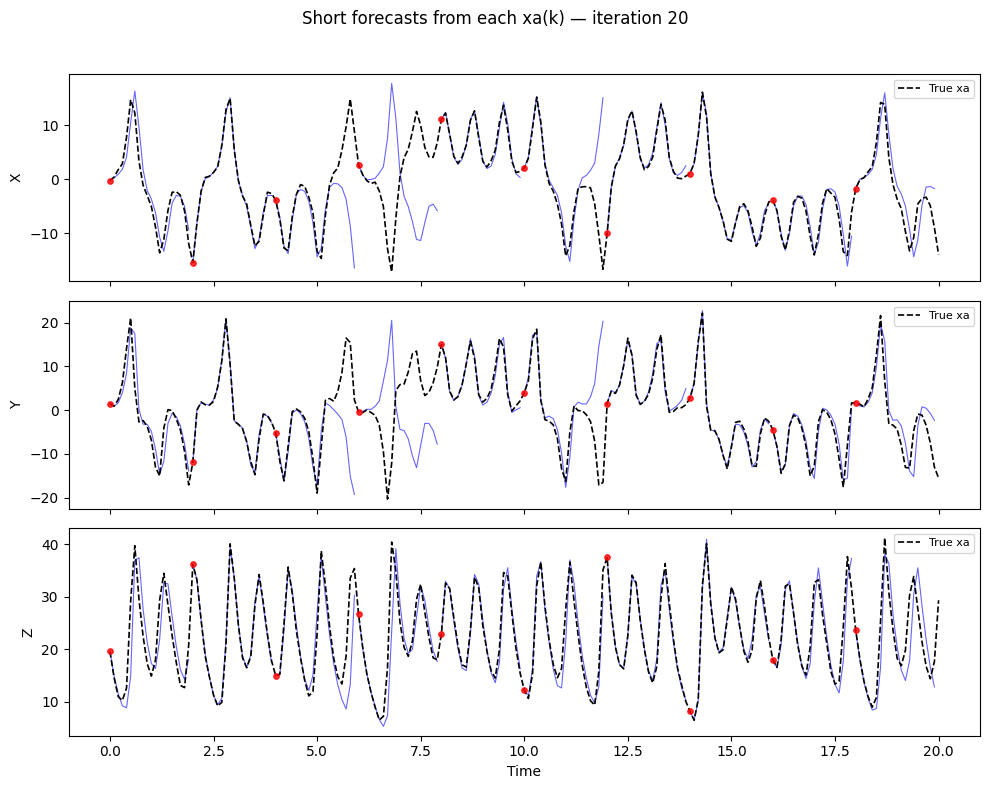

Saved plot to: origen_l63/L63_6_ML_model_fc_test_1.png


In [11]:
# =========================================================
# Cell 10: Variable-by-variable short forecasts from each xa(k)
#          with start markers
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import matplotlib.pyplot as plt
import torch
import numpy as np

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# use same device as the model
device = next(model.parameters()).device
print("Using device:", device)

n_forecast = 20     # forecast length
skip = 20           # start forecast every 5th time step

xa_true = xa_all[iter_to_train]
model.eval()
comps = ["X", "Y", "Z"]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# --- loop over start points and forecasts ---
with torch.no_grad():
    for k0 in range(0, len(t) - n_forecast, skip):
        xa_pred = np.zeros((n_forecast, 3))
        xa_pred[0] = xa_true[k0]
        for k in range(1, n_forecast):
            x_in = torch.tensor(xa_pred[k-1], dtype=torch.float32, device=device)
            xa_pred[k] = model(x_in).detach().cpu().numpy()

        t_fore = t[k0 : k0 + n_forecast]

        # plot each forecast in gray
        for i in range(3):
            axs[i].plot(t_fore, xa_pred[:, i],
                        color='blue', lw=0.8, alpha=0.6)
            # add dot at forecast start
            axs[i].scatter(t[k0], xa_pred[0, i],
                           color='red', s=15, zorder=3, alpha=0.8)

# --- plot true trajectory ---
for i, comp in enumerate(comps):
    axs[i].plot(t, xa_true[:, i], '--', color='black', lw=1.2, label='True xa')
    axs[i].set_ylabel(comp)
    axs[i].legend(fontsize=8, loc='upper right')

axs[-1].set_xlabel("Time")
fig.suptitle(f"Short forecasts from each xa(k) — iteration {iter_to_train+1}", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("L63_6_ML_model_fc_test_1.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_6_ML_model_fc_test_1.png", os.path.join(OUTDIR, "L63_6_ML_model_fc_test_1.png"))
print(f"Saved plot to: {OUTDIR}/L63_6_ML_model_fc_test_1.png")

Using device: mps:0
Epoch    0 | total=0.119684  one-step=0.077341
Epoch  200 | total=0.262358  one-step=0.082195
Epoch  400 | total=0.192215  one-step=0.081132
Epoch  600 | total=0.148517  one-step=0.087396
Epoch  800 | total=0.368573  one-step=0.083508
Epoch 1000 | total=0.238213  one-step=0.083239
Epoch 1200 | total=0.412321  one-step=0.083814
Epoch 1400 | total=0.229758  one-step=0.085041
Epoch 1600 | total=0.278304  one-step=0.085113
Epoch 1800 | total=0.151420  one-step=0.085769


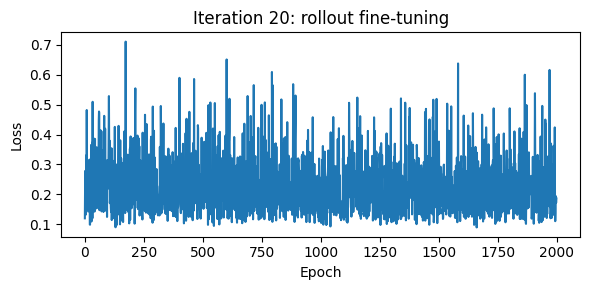

Saved plot to: origen_l63/L63_4_train_2.png


In [12]:
# =========================================================
# Cell 11: Gentle rollout fine-tuning (improves stability)
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# use same device as the model
device = next(model.parameters()).device
print("Using device:", device)

# --- fine-tuning parameters ---
extra_epochs = 2000        # a few thousand steps is usually enough
lr_fine = 1e-4             # smaller learning rate
nroll = 4                  # short rollout length
alpha = 0.3                # rollout-loss weight

optimizer = optim.Adam(model.parameters(), lr=lr_fine)
loss_fn = nn.MSELoss()
losses_roll = []

# --- prepare tensors once ---
xa = xa_all[iter_to_train]
xa_t = torch.tensor(xa, dtype=torch.float32, device=device)

for epoch in range(extra_epochs):
    optimizer.zero_grad()

    # one-step loss
    y_pred = model(xa_t[:-1])
    loss1 = loss_fn(y_pred, xa_t[1:])

    # short rollout loss (random start points)
    rollout_loss = 0.0
    n_batch = 32
    T = len(xa_t)
    start_idx = torch.randint(0, T - nroll - 1, (n_batch,), device=device)
    for idx in start_idx:
        x = xa_t[idx]
        for r in range(nroll):
            x = model(x)
            rollout_loss += loss_fn(x, xa_t[idx + r + 1])
    rollout_loss /= n_batch * nroll

    # combined loss
    loss = (1 - alpha) * loss1 + alpha * rollout_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    losses_roll.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | total={loss.item():.6f}  one-step={loss1.item():.6f}")

# --- plot fine-tuning diagnostics ---
plt.figure(figsize=(6,3))
plt.plot(losses_roll)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Iteration {iter_to_train+1}: rollout fine-tuning")
plt.tight_layout()
plt.savefig("L63_4_train_2.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_4_train_2.png", os.path.join(OUTDIR, "L63_4_train_2.png"))
print(f"Saved plot to: {OUTDIR}/L63_4_train_2.png")

Using device: mps:0


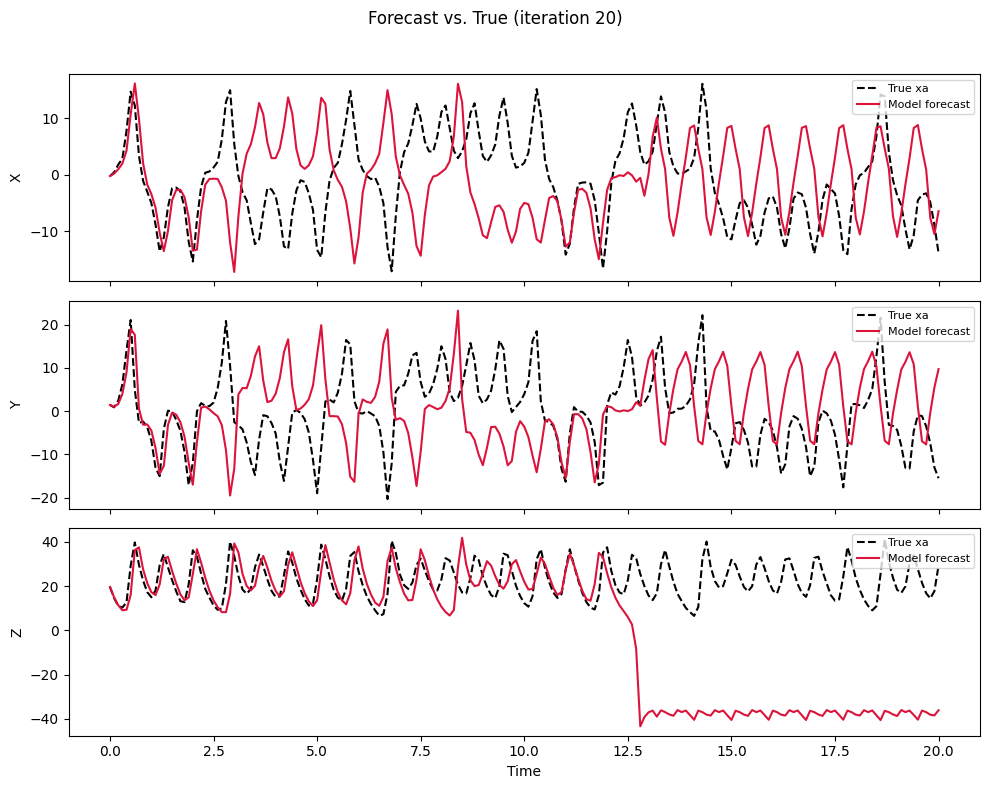

Saved plot to: origen_l63/L63_5_trajectory_test_2.png


In [13]:
# =========================================================
# Cell 12: Evaluate rollout forecast after fine-tuning
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# use same device as the model
device = next(model.parameters()).device
print("Using device:", device)

# --- evaluation: roll out forecasts from xa(k) initial ---
xa_true = xa_all[iter_to_train]
xa_pred = np.zeros_like(xa_true)
xa_pred[0] = xa_true[0]
model.eval()
with torch.no_grad():
    for k in range(len(t)-1):
        x_in = torch.tensor(xa_pred[k], dtype=torch.float32, device=device)
        xa_pred[k+1] = model(x_in).detach().cpu().numpy()

# --- plot comparison (forecast vs true xa) ---
fig, axs = plt.subplots(3,1, figsize=(10,8), sharex=True)
comps = ["X", "Y", "Z"]
for i, comp in enumerate(comps):
    axs[i].plot(t, xa_true[:, i], '--', label="True xa", color='black')
    axs[i].plot(t, xa_pred[:, i], label="Model forecast", color='crimson')
    axs[i].set_ylabel(comp)
    axs[i].legend(loc='upper right', fontsize=8)
axs[-1].set_xlabel("Time")
fig.suptitle(f"Forecast vs. True (iteration {iter_to_train+1})", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig("L63_5_trajectory_test_2.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_5_trajectory_test_2.png", os.path.join(OUTDIR, "L63_5_trajectory_test_2.png"))
print(f"Saved plot to: {OUTDIR}/L63_5_trajectory_test_2.png")


Using device: mps:0


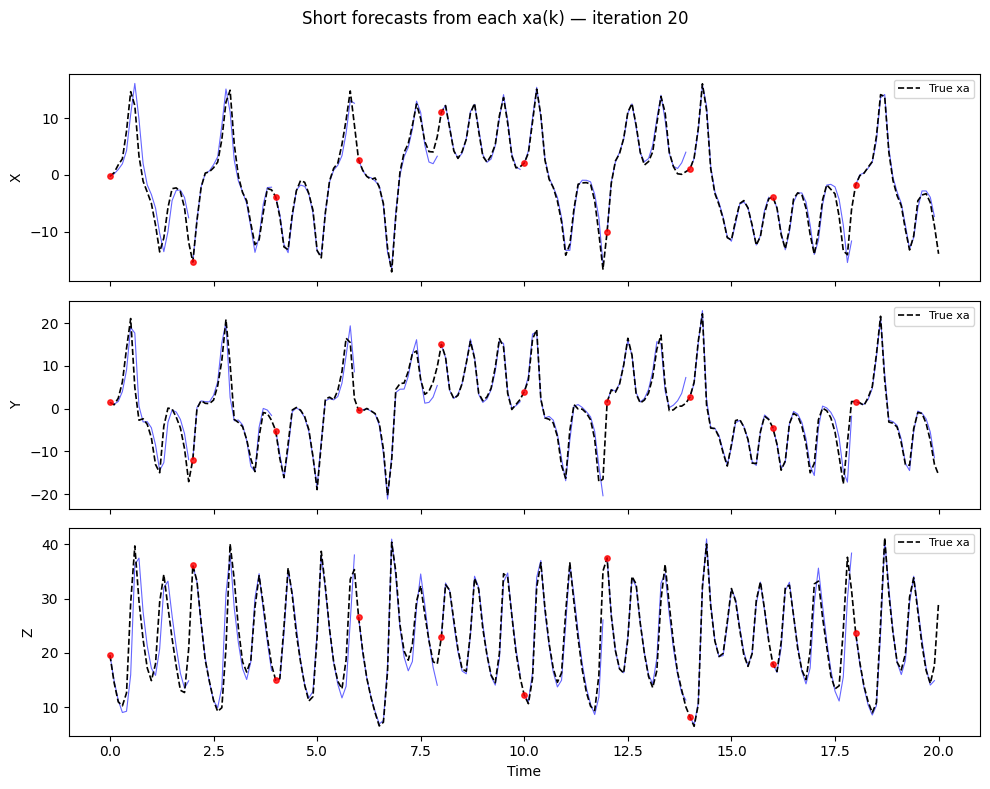

Saved plot to: origen_l63/L63_6_ML_model_fc_test_2.png


In [14]:
# =========================================================
# Cell 13: Variable-by-variable short forecasts from each xa(k)
#          with start markers (after fine-tuning)
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import matplotlib.pyplot as plt
import torch
import numpy as np

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# use same device as the model
device = next(model.parameters()).device
print("Using device:", device)

n_forecast = 20     # forecast length
skip = 20           # start forecast every 5th time step

xa_true = xa_all[iter_to_train]
model.eval()
comps = ["X", "Y", "Z"]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# --- loop over start points and forecasts ---
with torch.no_grad():
    for k0 in range(0, len(t) - n_forecast, skip):
        xa_pred = np.zeros((n_forecast, 3))
        xa_pred[0] = xa_true[k0]
        for k in range(1, n_forecast):
            x_in = torch.tensor(xa_pred[k-1], dtype=torch.float32, device=device)
            xa_pred[k] = model(x_in).detach().cpu().numpy()

        t_fore = t[k0 : k0 + n_forecast]

        # plot each forecast in gray
        for i in range(3):
            axs[i].plot(t_fore, xa_pred[:, i],
                        color='blue', lw=0.8, alpha=0.6)
            # add dot at forecast start
            axs[i].scatter(t[k0], xa_pred[0, i],
                           color='red', s=15, zorder=3, alpha=0.8)

# --- plot true trajectory ---
for i, comp in enumerate(comps):
    axs[i].plot(t, xa_true[:, i], '--', color='black', lw=1.2, label='True xa')
    axs[i].set_ylabel(comp)
    axs[i].legend(fontsize=8, loc='upper right')

axs[-1].set_xlabel("Time")
fig.suptitle(f"Short forecasts from each xa(k) — iteration {iter_to_train+1}", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("L63_6_ML_model_fc_test_2.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_6_ML_model_fc_test_2.png", os.path.join(OUTDIR, "L63_6_ML_model_fc_test_2.png"))
print(f"Saved plot to: {OUTDIR}/L63_6_ML_model_fc_test_2.png")

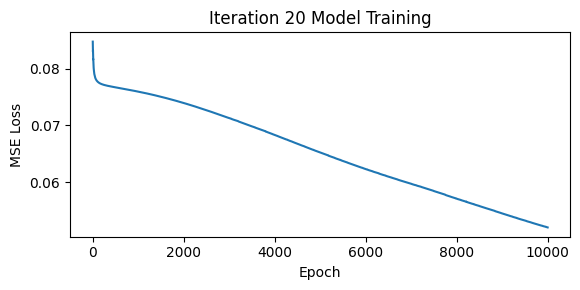

Saved plot to: origen_l63/L63_4_train_3.png


In [15]:
# =========================================================
# Cell 14: Additional training phase (continue training)
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# --- training loop ---
losses = []
n_epochs2 = 10000
for epoch in range(n_epochs2):
    optimizer.zero_grad()
    y_pred = model(X_t)
    loss = loss_fn(y_pred, Y_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# --- training diagnostics ---
plt.figure(figsize=(6,3))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Iteration {iter_to_train+1} Model Training")
plt.tight_layout()
plt.savefig("L63_4_train_3.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_4_train_3.png", os.path.join(OUTDIR, "L63_4_train_3.png"))
print(f"Saved plot to: {OUTDIR}/L63_4_train_3.png")

Using device: mps:0


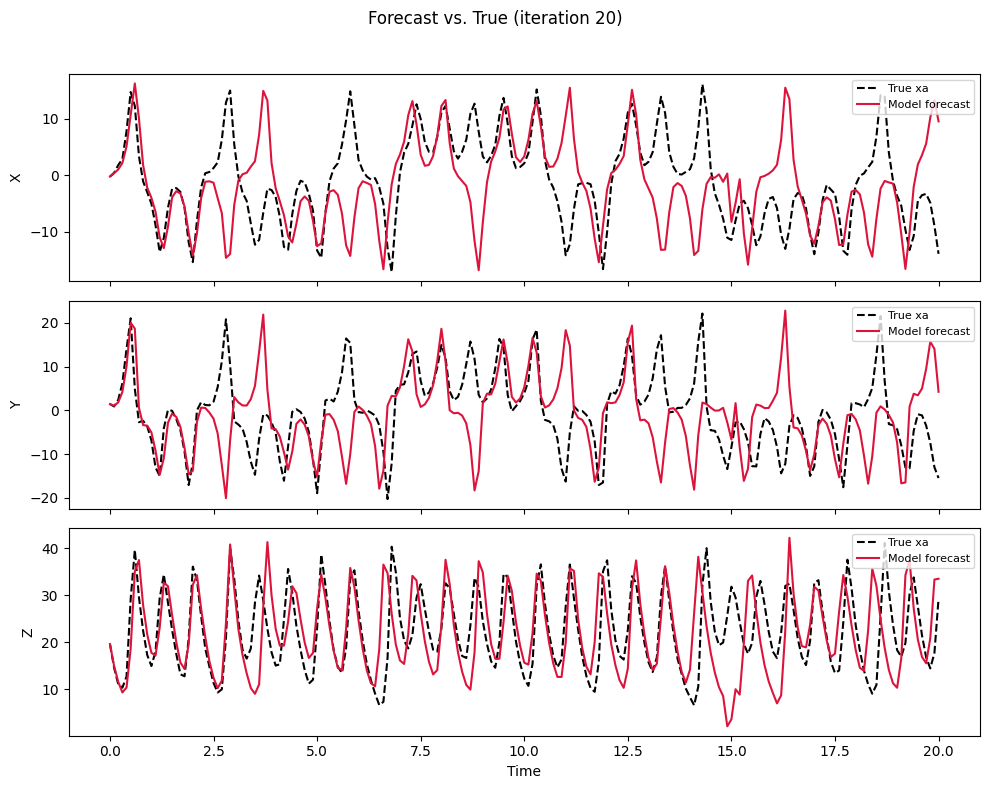

Saved plot to: origen_l63/L63_5_trajectory_test_3.png


In [16]:
# =========================================================
# Cell 15: Evaluate rollout forecast after additional training
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# use same device as the model
device = next(model.parameters()).device
print("Using device:", device)

# --- evaluation: roll out forecasts from xa(k) initial ---
xa_true = xa_all[iter_to_train]
xa_pred = np.zeros_like(xa_true)
xa_pred[0] = xa_true[0]
model.eval()
with torch.no_grad():
    for k in range(len(t)-1):
        x_in = torch.tensor(xa_pred[k], dtype=torch.float32, device=device)
        xa_pred[k+1] = model(x_in).detach().cpu().numpy()

# --- plot comparison (forecast vs true xa) ---
fig, axs = plt.subplots(3,1, figsize=(10,8), sharex=True)
comps = ["X", "Y", "Z"]
for i, comp in enumerate(comps):
    axs[i].plot(t, xa_true[:, i], '--', label="True xa", color='black')
    axs[i].plot(t, xa_pred[:, i], label="Model forecast", color='crimson')
    axs[i].set_ylabel(comp)
    axs[i].legend(loc='upper right', fontsize=8)
axs[-1].set_xlabel("Time")
fig.suptitle(f"Forecast vs. True (iteration {iter_to_train+1})", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig("L63_5_trajectory_test_3.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_5_trajectory_test_3.png", os.path.join(OUTDIR, "L63_5_trajectory_test_3.png"))
print(f"Saved plot to: {OUTDIR}/L63_5_trajectory_test_3.png")


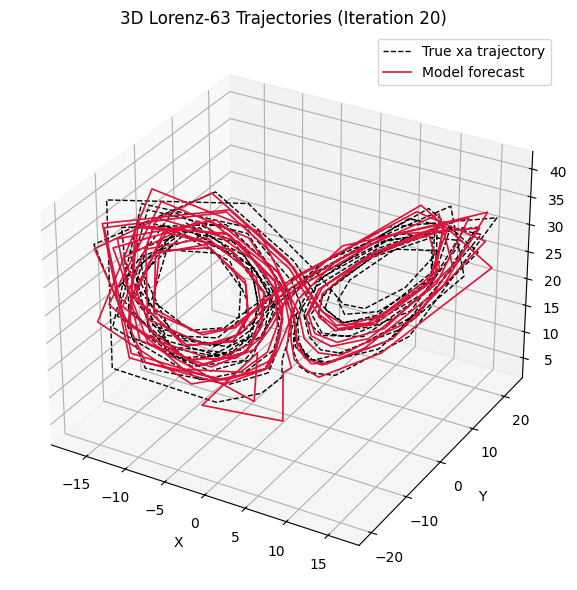

Saved plot to: origen_l63/L63_5_trajectory_test2.png


In [17]:
# =========================================================
# Cell 16: 3D trajectory plot – true vs learned model forecast
# Output folder: origen_l63/
# =========================================================
import os
import shutil
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# --- true trajectory (from assimilation analysis) ---
ax.plot(
    xa_true[:, 0], xa_true[:, 1], xa_true[:, 2],
    color='black', lw=1.0, linestyle='--', label='True xa trajectory'
)

# --- model forecast trajectory ---
ax.plot(
    xa_pred[:, 0], xa_pred[:, 1], xa_pred[:, 2],
    color='crimson', lw=1.2, label='Model forecast'
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Lorenz-63 Trajectories (Iteration {iter_to_train+1})')
ax.legend()
plt.tight_layout()
plt.savefig("L63_5_trajectory_test2.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_5_trajectory_test2.png", os.path.join(OUTDIR, "L63_5_trajectory_test2.png"))
print(f"Saved plot to: {OUTDIR}/L63_5_trajectory_test2.png")

Using device: mps:0


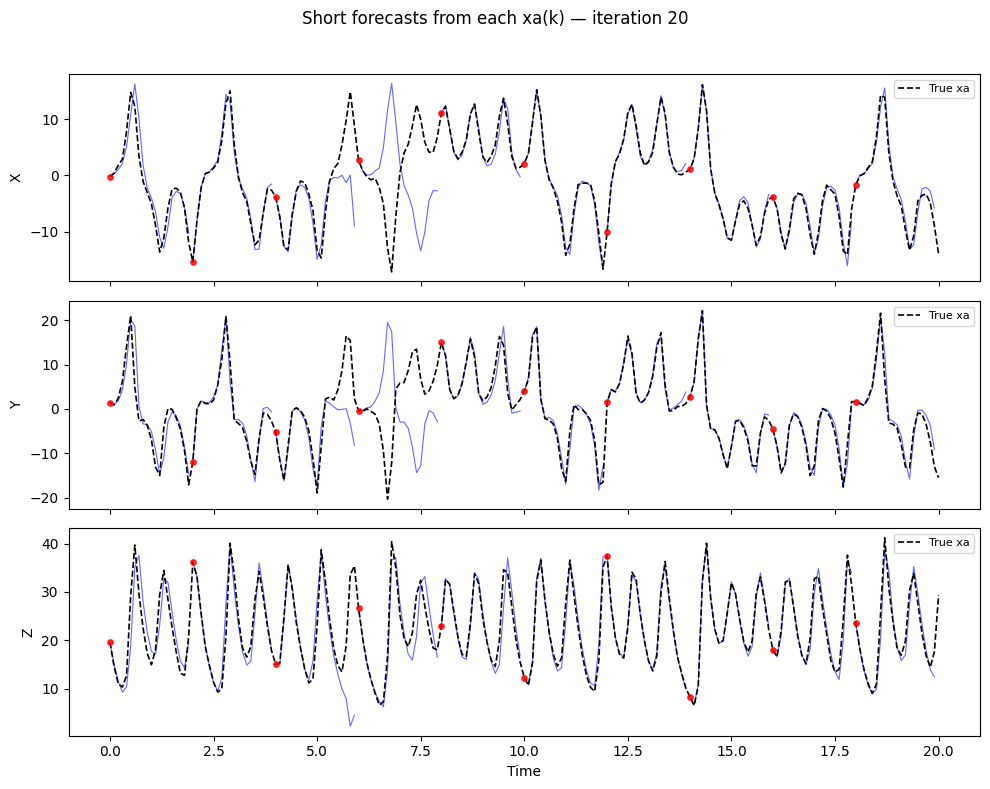

Saved plot to: origen_l63/L63_6_ML_model_fc_test_3.png


In [18]:
# =========================================================
# Cell 17: Variable-by-variable short forecasts from each xa(k)
#          with start markers (after additional training)
# Output folder: origen_l63/
# =========================================================
import os
import shutil
import matplotlib.pyplot as plt
import torch
import numpy as np

# make sure output folder exists
OUTDIR = "origen_l63"
os.makedirs(OUTDIR, exist_ok=True)

# use same device as the model
device = next(model.parameters()).device
print("Using device:", device)

n_forecast = 20     # forecast length
skip = 20           # start forecast every 5th time step

xa_true = xa_all[iter_to_train]
model.eval()
comps = ["X", "Y", "Z"]

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# --- loop over start points and forecasts ---
with torch.no_grad():
    for k0 in range(0, len(t) - n_forecast, skip):
        xa_pred = np.zeros((n_forecast, 3))
        xa_pred[0] = xa_true[k0]
        for k in range(1, n_forecast):
            x_in = torch.tensor(xa_pred[k-1], dtype=torch.float32, device=device)
            xa_pred[k] = model(x_in).detach().cpu().numpy()

        t_fore = t[k0 : k0 + n_forecast]

        # plot each forecast in gray
        for i in range(3):
            axs[i].plot(t_fore, xa_pred[:, i],
                        color='blue', lw=0.8, alpha=0.6)
            # add dot at forecast start
            axs[i].scatter(t[k0], xa_pred[0, i],
                           color='red', s=15, zorder=3, alpha=0.8)

# --- plot true trajectory ---
for i, comp in enumerate(comps):
    axs[i].plot(t, xa_true[:, i], '--', color='black', lw=1.2, label='True xa')
    axs[i].set_ylabel(comp)
    axs[i].legend(fontsize=8, loc='upper right')

axs[-1].set_xlabel("Time")
fig.suptitle(f"Short forecasts from each xa(k) — iteration {iter_to_train+1}", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("L63_6_ML_model_fc_test_3.png")
plt.show()

# copy plot into origen_l63/ without touching your save line above
shutil.copy("L63_6_ML_model_fc_test_3.png", os.path.join(OUTDIR, "L63_6_ML_model_fc_test_3.png"))
print(f"Saved plot to: {OUTDIR}/L63_6_ML_model_fc_test_3.png")